In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble.partial_dependence import plot_partial_dependence
%matplotlib inline

In [41]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [171]:
df = pd.read_csv('data/churn.csv')

In [172]:
df.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


- __city__: city this user signed up in
- __phone__: primary device for this user
- __signup_date__: date of account registration; in the form `YYYYMMDD`
- __last_trip_date__: the last time this user completed a trip; in the form `YYYYMMDD`
- __avg_dist__: the average distance (in miles) per trip taken in the first 30 days after signup
- __avg_rating_by_driver__: the rider’s average rating over all of their trips
- __avg_rating_of_driver__: the rider’s average rating of their drivers over all of their trips 
- __surge_pct__: the percent of trips taken with surge multiplier > 1
- __avg_surge__: The average surge multiplier over all of this user’s trips 
- __trips_in_first_30_days__: the number of trips this user took in the first 30 days after signing up
- __luxury_car_user__: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise
- __weekday_pct__: the percent of the user’s trips occurring during a weekday

In [173]:
df['Churn'] = (pd.to_datetime(df['last_trip_date']) < '2014-06-01').astype(int)
df.drop('last_trip_date', axis=1, inplace=True)

In [174]:
df_null = df[df.isnull().any(axis=1)]

In [175]:
for col in df.columns:
    print '{}: {}'.format(col, df_null[col].isnull().sum())

avg_dist: 0
avg_rating_by_driver: 201
avg_rating_of_driver: 8122
avg_surge: 0
city: 0
phone: 396
signup_date: 0
surge_pct: 0
trips_in_first_30_days: 0
luxury_car_user: 0
weekday_pct: 0
Churn: 0


# Train/Test Split

In [254]:
y = df['Churn']
X = df.ix[:, df.columns != 'Churn']

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [178]:
def clean_train(df):
    # Drop 'signup_date'
    df = df.drop('signup_date', axis=1)

    # Fill null values in 'avg_rating_by_driver' with mean of non-null values
    by_driver_fill = np.mean(df['avg_rating_by_driver'])
    df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(by_driver_fill)

    # Fill null values in 'avg_rating_of_driver' with 0s
    of_driver_fill = 0
    df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(of_driver_fill)

    # Fill null values in 'phone' with mode of non-null values
    phone_fill = scs.mode(df['phone'])[0][0]
    df['phone'] = df['phone'].fillna(phone_fill)

    # Dummify 'phone' column
    phone_dummies = pd.get_dummies(df['phone'])
    df[phone_dummies.columns] = phone_dummies
    df = df.drop('phone', axis=1)

    # Dummify 'city' column
    city_dummies = pd.get_dummies(df['city'])
    df[city_dummies.columns] = city_dummies
    df = df.drop('city', axis=1)

    return df, by_driver_fill, of_driver_fill, phone_fill, phone_dummies.columns.tolist(), city_dummies.columns.tolist()

In [179]:
def clean_test(df, by_driver_fill, of_driver_fill, phone_fill, phone_columns, city_columns):
    # Drop 'signup_date'
    df = df.drop('signup_date', axis=1)

    # Fill null values in 'avg_rating_by_driver' with mean of non-null values
    df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(by_driver_fill)

    # Fill null values in 'avg_rating_of_driver' with 0s
    df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(of_driver_fill)

    # Fill null values in 'phone' with mode of non-null values
    df['phone'] = df['phone'].fillna(phone_fill)

    # Dummify 'phone' column
    phone_dummies = pd.get_dummies(df['phone'])
    df[phone_dummies.columns] = phone_dummies
    df = df.drop('phone', axis=1)

    # Dummify 'city' column
    city_dummies = pd.get_dummies(df['city'])
    df[city_dummies.columns] = city_dummies
    df = df.drop('city', axis=1)

    all_cols = set(df.columns)
    for col in phone_columns + city_columns:
        if col not in all_cols:
            df[col] = 0

    return df

# Null Data

In [256]:
X_train, by_driver_fill, of_driver_fill, phone_fill, phone_columns, city_columns \
    = clean_train(X_train)

# Logistic Regression

In [181]:
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
          AdaBoostClassifier(), KNeighborsClassifier()]

In [182]:
for model in models:
        score = cross_val_score(model, X_train, y_train, scoring='recall', cv=5)
        print '{}: {}'.format(model.__class__.__name__, score.mean())

LogisticRegression: 0.857757898677
RandomForestClassifier: 0.778455179554
GradientBoostingClassifier: 0.862530728893
AdaBoostClassifier: 0.861209730363
KNeighborsClassifier: 0.817787381709


In [232]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
knc = KNeighborsClassifier()

In [233]:
models = [lr, rfc, gbc, abc, knc]

for model in models:
    model.fit(X_train, y_train)

In [234]:
print rfc.__class__.__name__
print X_train.columns[np.argsort(rfc.feature_importances_)]

RandomForestClassifier
Index([u'Winterfell', u'iPhone', u'Astapor', u'Android', u'luxury_car_user',
       u'King's Landing', u'avg_surge', u'trips_in_first_30_days',
       u'avg_rating_of_driver', u'surge_pct', u'avg_rating_by_driver',
       u'weekday_pct', u'avg_dist'],
      dtype='object')


In [235]:
print gbc.__class__.__name__
print X_train.columns[np.argsort(gbc.feature_importances_)]

GradientBoostingClassifier
Index([u'Winterfell', u'iPhone', u'Android', u'avg_surge', u'Astapor',
       u'avg_rating_of_driver', u'luxury_car_user', u'King's Landing',
       u'avg_rating_by_driver', u'trips_in_first_30_days', u'avg_dist',
       u'surge_pct', u'weekday_pct'],
      dtype='object')


In [236]:
print abc.__class__.__name__
print X_train.columns[np.argsort(abc.feature_importances_)]

AdaBoostClassifier
Index([u'Android', u'avg_surge', u'iPhone', u'Astapor', u'Winterfell',
       u'avg_rating_of_driver', u'luxury_car_user', u'King's Landing',
       u'avg_dist', u'trips_in_first_30_days', u'avg_rating_by_driver',
       u'weekday_pct', u'surge_pct'],
      dtype='object')


In [223]:
for i, f in enumerate(X_train.columns):
    print i, f

0 avg_dist
1 avg_rating_by_driver
2 avg_rating_of_driver
3 avg_surge
4 surge_pct
5 trips_in_first_30_days
6 luxury_car_user
7 weekday_pct
8 Android
9 iPhone
10 Astapor
11 King's Landing
12 Winterfell


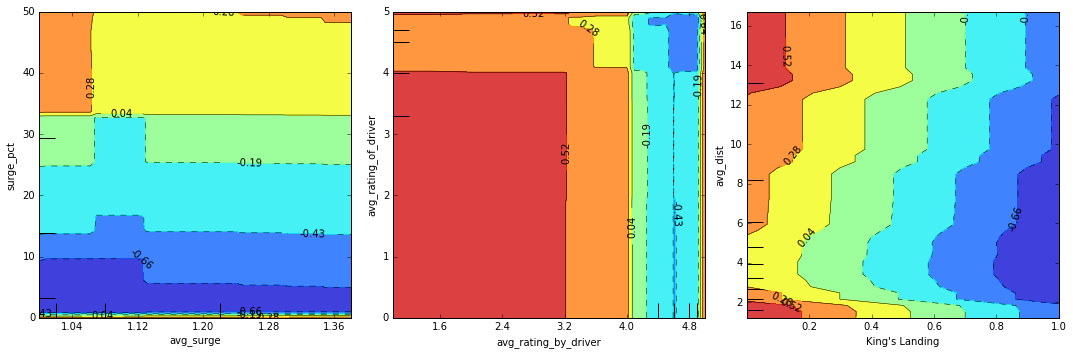

In [244]:
plot_partial_dependence(gbc, X_train,
                        features=[(3, 4), (1, 2), (11, 0)],
                        feature_names=X_train.columns,
                        n_jobs=3, grid_resolution=50, figsize=(15, 5))
plt.tight_layout()

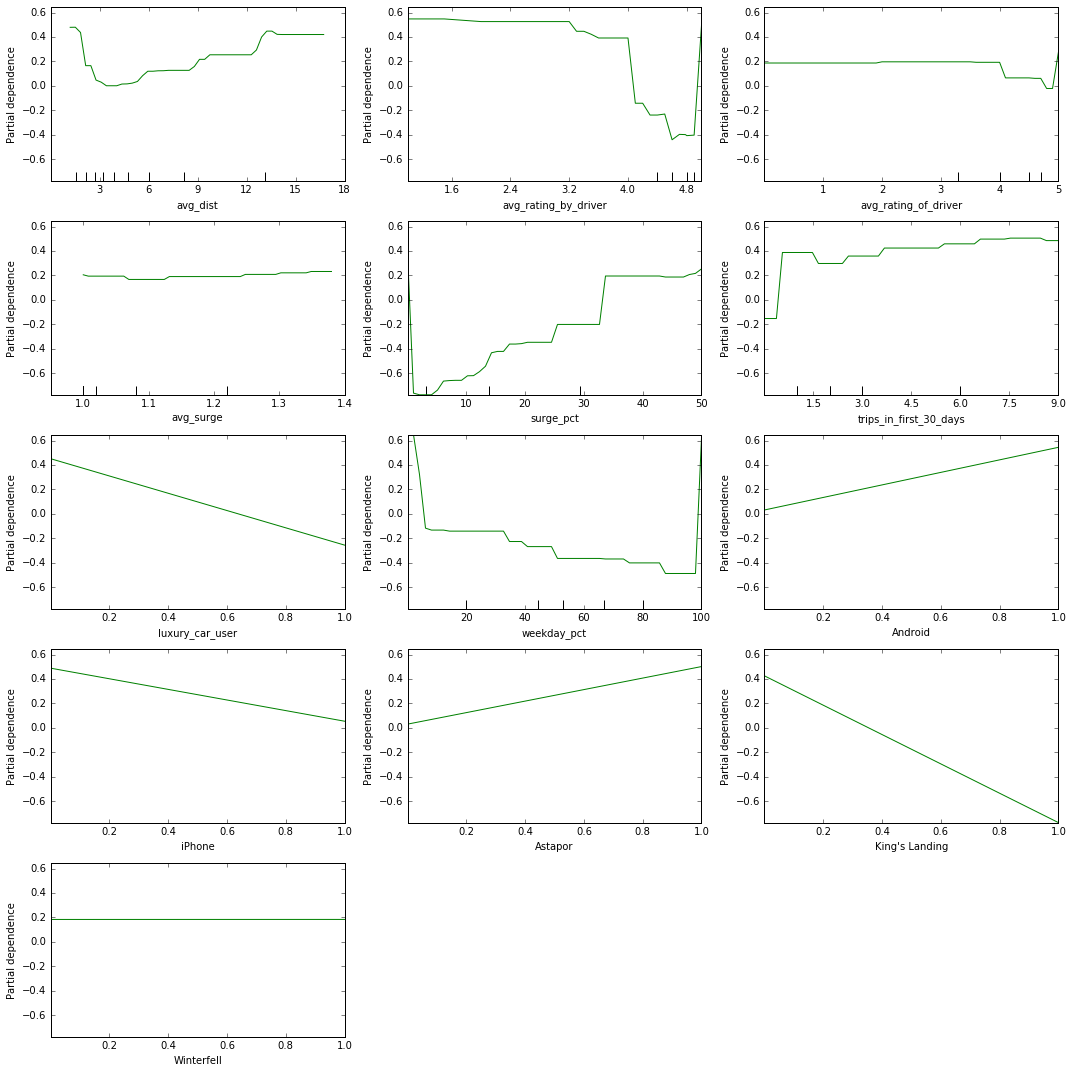

In [231]:
plot_partial_dependence(gbc, X_train, xrange(len(X_train.columns)),
                        feature_names=X_train.columns,
                        n_jobs=3, grid_resolution=50, figsize=(15, 15))
plt.tight_layout()
plt.savefig('gbc_pd_plots.png')

In [262]:
(df['city'] == 'Astapor').sum()

16534

In [280]:
'''
n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,
bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None
'''

rf_grid = {'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
           'criterion': ['gini', 'entropy'],
           'max_features': ['sqrt', 'log2', None],
           'max_depth': [1, 2, 4, None],
           'min_samples_split': [2, 4],
           'min_samples_leaf': [1, 2]
          }

rf_gridsearch = GridSearchCV(rfc, rf_grid, n_jobs=-1, verbose=True, scoring='recall', cv=5).fit(X_train, y_train)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min


KeyboardInterrupt: 

In [ ]:
best_rfc = rf_gridsearch.best_estimator_

In [ ]:
rf_gridsearch.best_params_

In [284]:
keep = ['surge_pct', 'luxury_car_user', "King's Landing"]

In [285]:
X_train_keep = X_train[keep]

In [286]:
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
          AdaBoostClassifier(), KNeighborsClassifier()]

for model in models:
        score = cross_val_score(model, X_train_keep, y_train, scoring='recall', cv=5)
        print '{}: {}'.format(model.__class__.__name__, score.mean())

LogisticRegression: 0.877018959876
RandomForestClassifier: 0.909319630512
GradientBoostingClassifier: 0.89981678648
AdaBoostClassifier: 0.899262906044
KNeighborsClassifier: 0.786243152304


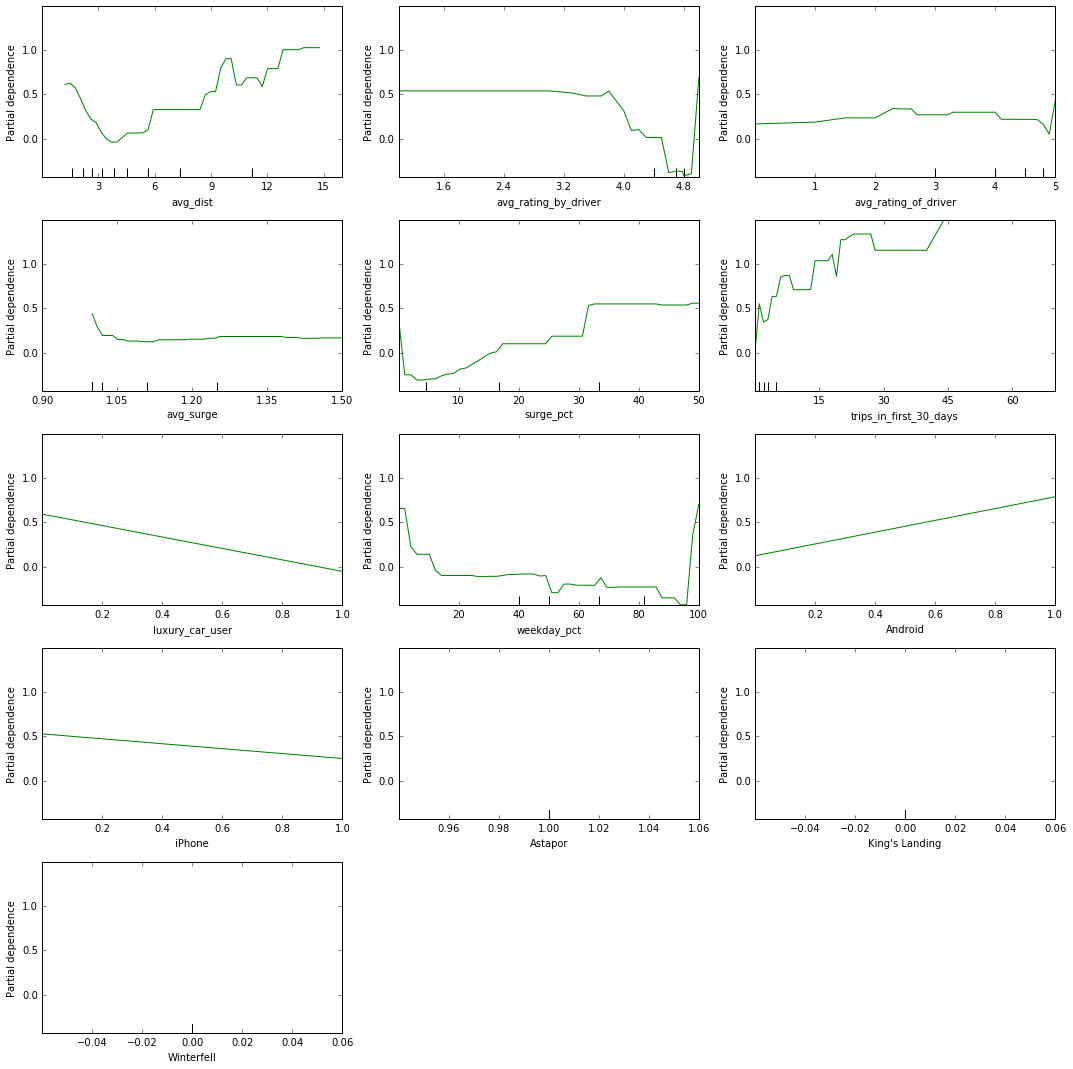

In [273]:
X_train_astapor = X_train[X_train['Astapor'] == 1]
y_train_astapor = y_train[X_train['Astapor'] == 1]

gbc_astapor = GradientBoostingClassifier()
gbc_astapor.fit(X_train_astapor, y_train_astapor)

plot_partial_dependence(gbc_astapor, X_train_astapor, xrange(len(X_train.columns)),
                        feature_names=X_train.columns,
                        n_jobs=3, grid_resolution=50, figsize=(15, 15))
plt.tight_layout()
plt.savefig('gbc_astapor_pd_plots.png')

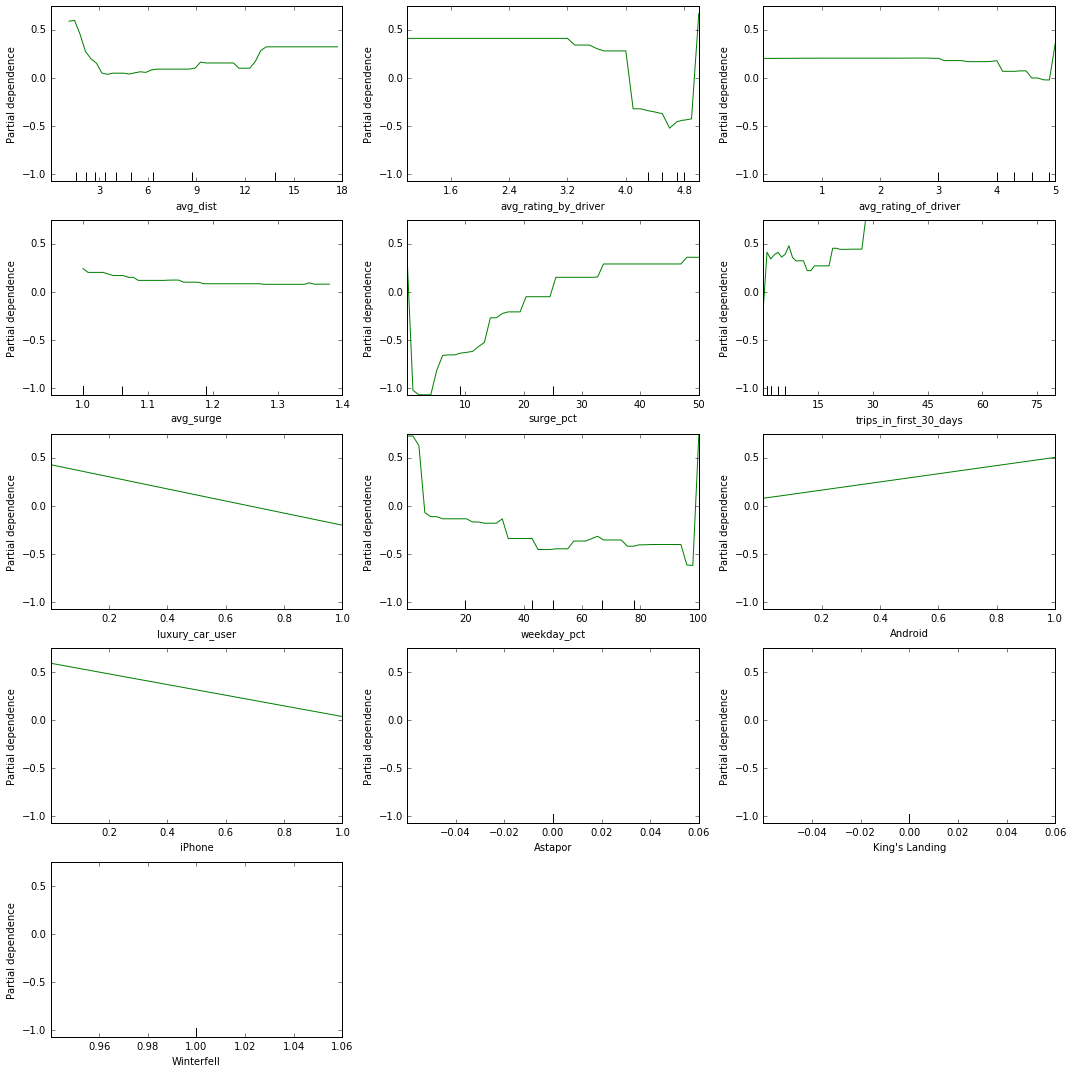

In [274]:
X_train_winterfell = X_train[X_train['Winterfell'] == 1]
y_train_winterfell = y_train[X_train['Winterfell'] == 1]

gbc_winterfell = GradientBoostingClassifier()
gbc_winterfell.fit(X_train_winterfell, y_train_winterfell)

plot_partial_dependence(gbc_winterfell, X_train_winterfell, xrange(len(X_train.columns)),
                        feature_names=X_train.columns,
                        n_jobs=3, grid_resolution=50, figsize=(15, 15))
plt.tight_layout()
plt.savefig('gbc_winterfell_pd_plots.png')

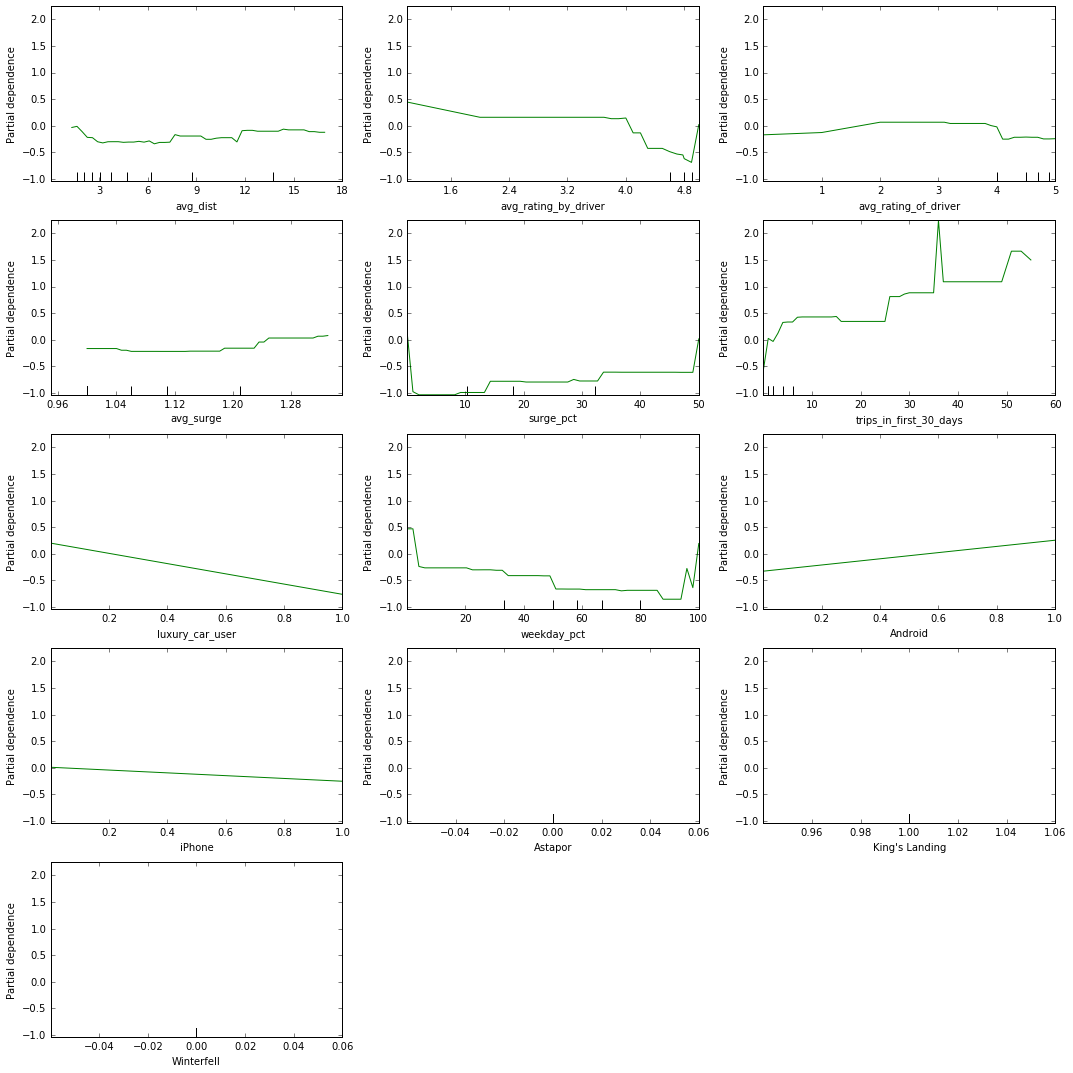

In [275]:
X_train_king = X_train[X_train["King's Landing"] == 1]
y_train_king = y_train[X_train["King's Landing"] == 1]

gbc_king = GradientBoostingClassifier()
gbc_king.fit(X_train_king, y_train_king)

plot_partial_dependence(gbc_king, X_train_king, xrange(len(X_train.columns)),
                        feature_names=X_train.columns,
                        n_jobs=3, grid_resolution=50, figsize=(15, 15))
plt.tight_layout()
plt.savefig('gbc_king_pd_plots.png')

In [287]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

gbc.score(X_test, y_test, scoring='recall')

TypeError: score() got an unexpected keyword argument 'scoring'